In [1]:
import os
os.environ["MKL_NUM_THREADS"]="16" 
os.environ["NUMEXPR_NUM_THREADS"]='16'
os.environ["OMP_NUM_THREADS"]='16'
import matplotlib.pyplot as plt
import types
import numpy as np
import tqdm.notebook
from mmd import MMD_3_Sample_Test
import torch
from torch import optim
import torch.nn as nn
import torch.utils
import torch.distributions as td

%matplotlib inline

from importlib import reload


import Generators, Features, Data, Likelihoods

from KernelWakeSleep import *

import Models

device = torch.device("cpu")
reload(Data)
reload(Models)

<module 'Models' from '/nfs/ghome/live/kevinli/Code/kws/Models.py'>

In [2]:
reload(Generators)
reload(Features)
reload(Likelihoods)

<module 'Likelihoods' from '/nfs/ghome/live/kevinli/Code/kws/Likelihoods.py'>

In [3]:
batch_size = 200
nsleep = 2000
nepoch = 10
nvalid = 200
torch.manual_seed(0)
np.random.seed(0)

# data

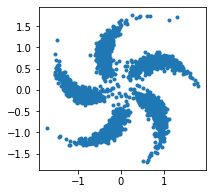

In [4]:
import numpy as np
import numpy.random as npr



def make_pinwheel_data(radial_std, tangential_std, num_classes, num_per_class, rate):
    rads = np.linspace(0, 2*np.pi, num_classes, endpoint=False)

    features = npr.randn(num_classes*num_per_class, 2) \
        * np.array([radial_std, tangential_std])
    features[:,0] += 1.
    labels = np.repeat(np.arange(num_classes), num_per_class)

    angles = rads[labels] + rate * np.exp(features[:,0]) * 1
    rotations = np.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
    rotations = np.reshape(rotations.T, (-1, 2, 2))

    return 1*npr.permutation(np.einsum('ti,tij->tj', features, rotations))
    

samples_per_cluster =500
num_clusters = 5
bending = 0.2

# rate = 0.2 for pinwheel, rate = 0.0 for GMM
train_data = make_pinwheel_data(0.3, 0.1, num_clusters, samples_per_cluster, bending)

train_data -= train_data.mean(0,keepdims=True)

plt.figure(figsize=(3,3))
plt.scatter(train_data[:,0], train_data[:,1], marker='.')

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(train_data)),
    batch_size=batch_size, shuffle=True)

In [5]:
reload(Models)
K = 10
D = 2
nh = 20
gmm =  Models.PinWheelGMM(K,D,nh=nh).float().to(device)

def sleep(gmm, nsleep):
    return gmm.sample_logp0(nsleep)

def draw_sample(gmm, nsleep):
    return gmm.sample_logp0(nsleep)[1]
# gmm.load_state_dict(torch.load( "models/kws/pinwheel_K%d_nh%d_%.1f_full_bayesian"%(K, nh, bending)))

In [6]:
s = draw_sample(gmm, 1000)
sigma = estimate_median_distance(s)
kernel_networks = [Features.Identity()]
kernel = Kernel(kernel_networks, sigma , lam=1e-2, train_sigma=True, train_lam=True)
kernel.float().to(device)

Kernel(
  (kernel_networks): ModuleList(
    (0): Identity()
  )
)

In [7]:

optimizer = optim.Adam(list(gmm.parameters()), lr=0.001)
kernel_optimizer = optim.Adam(kernel.parameters(), lr=0.001)


Elogps = []
losses = []

log_lams = []
log_sigmas = []

network_norms = []
kernel_network_norms = []
kernel_network_feat_norms = []
noise_stds = []
network_grad_norms = []

feat_mmds = []
recons = []

In [ ]:
import gc
gc.collect()

gmm.train()
kernel.train()
nsleep = 1000
with tqdm.notebook.tqdm(range(20000)) as t:
    for ei in t:

        for i, (X_tr,) in enumerate(train_loader):

            X_tr = X_tr.float().to(device)

            data_0, data_1, norm, nat = sleep(gmm, nsleep)
            data_0_val, data_1_val, norm_val, nat_val = sleep(gmm, nvalid)
            S_val = gmm.suff(data_1_val)
            
            if i % 1 == 0:
                
                kernel_optimizer.zero_grad()

                Elogp_val = KRR_2(gmm.suff, kernel, data_1_val, data_1, norm.detach(), nat.detach()).mean()
                
                loss_val = torch.mean((Elogp_val + norm_val - (nat_val * S_val).sum(-1))**2)

                loss_val.backward(retain_graph=False)
                                
                network_grad_norm = sum(map(lambda x: (x.grad**2).sum() if x.grad is not None else 0, kernel.parameters()))
                
                kernel_optimizer.step()

                losses += loss_val.detach().cpu().numpy(),

                log_lams += kernel.log_lam.cpu().detach().numpy().copy(),
                log_sigmas += kernel.log_sigma.cpu().detach().numpy().copy(),

            Elogp = KRR_2(gmm.suff, kernel, X_tr, data_1, norm, nat).mean()
            network_norm = sum(map(lambda x: (x**2).sum(), gmm.parameters()))

            y_cov = torch.einsum("ijk,ilk->ijl", gmm.chol, gmm.chol)
            gen_loss = -Elogp \
                        + (gmm.alpha-torch.logsumexp(gmm.alpha,0)).sum()*1e-2 + \
                        (gmm.mu.norm()**2)*1e-3 + network_norm * 1e-3 \
                        + (1e-6 * torch.logdet(y_cov) + 
                           1e-6 * torch.einsum("ijj->i", torch.inverse(y_cov))).sum()


            Elogps += Elogp.mean().detach().cpu().numpy(),

            optimizer.zero_grad()
            gen_loss.backward(retain_graph=False)

            network_norms += network_norm,
            network_grad_norm = sum(map(lambda x: (x.grad**2).sum() if x.grad is not None else 0, gmm.parameters()))
            network_grad_norms += network_grad_norm,


            optimizer.step()


            if hasattr(gmm, "log_std"):
                noise_stds += gmm.log_std.exp().detach().cpu().numpy(),
        t.set_postfix(Elogp=Elogp.item())

torch.save(gmm.state_dict(), "models/kws/pinwheel_K%d_nh%d_%.1f_full_bayesian_2"%(K, nh, bending))

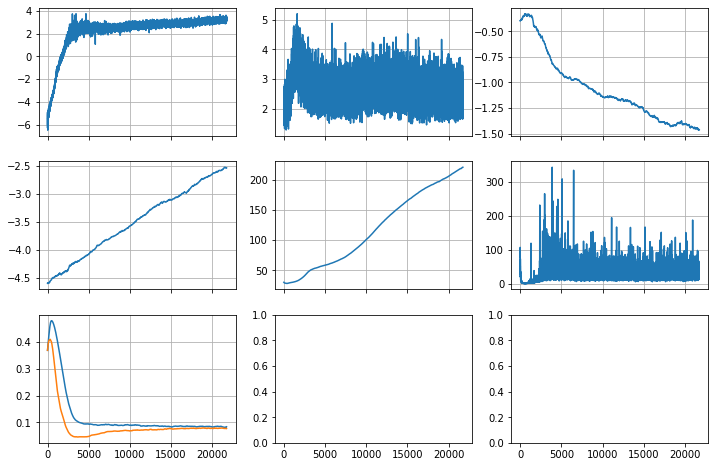

In [37]:
params = [Elogps,losses, log_sigmas, 
          log_lams, network_norms, network_grad_norms,
          noise_stds]

nplot = len(params)
fig, axes = plt.subplots(3,3, figsize=(12,8), sharex=True)
axes = np.ravel(axes)
for i in range(nplot):
    axes[i].plot(params[i])
    axes[i].grid(True)
# axes[0].set_xlim([20000,2000])

<BarContainer object of 10 artists>

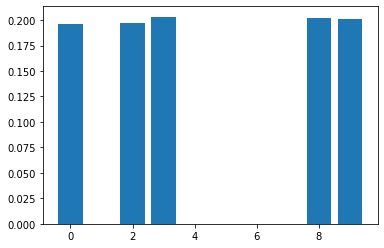

In [38]:
plt.bar(range(10),gmm.alpha.softmax(0).detach().cpu().numpy())

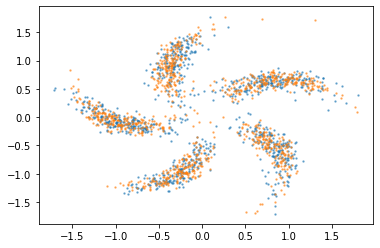

In [39]:
x = draw_sample(gmm,1000).cpu().numpy()

plt.scatter(*x.T, s=2, alpha=0.5)
plt.scatter(*train_data[:1000].T,s=2, alpha=0.5)

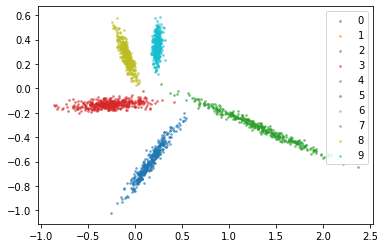

In [41]:
x_real = draw_sample(gmm,2000).cpu().numpy()

latents, x = gmm.sample_logp0(2000)[:2]
z, tau, mean, y = [z.detach().cpu().numpy() if z is not None else None for z in latents[1:]]
x = x.cpu().numpy()
x = y
# plt.scatter(*x_real.T, s=2, color="k", alpha=0.5)
for i in range(10):
    plt.scatter(x[z == i,0], x[z == i,1], 3, label=i, alpha=0.5)
plt.legend()

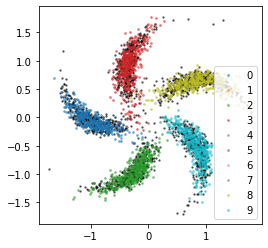

In [42]:
x_real = train_data[:2000]


latents, x = gmm.sample_logp0(2000)[:2]
z, tau, mean, y = [z.detach().cpu().numpy() if z is not None else None for z in latents[1:]]
x = x.cpu().numpy()

plt.figure(figsize=(4,4))
plt.scatter(*x_real.T, s=2, color="k", alpha=0.5)
for i in range(10):
    plt.scatter(x[z == i,0], x[z == i,1], 3, label=i, alpha=0.5)
plt.legend()

In [43]:
np.savez("results/kws/pinwheel_K%d_nh%d_%.1f_full_bayesian_2"%(K, nh, bending), 
         z = z, x=x, y=y, x_real = x_real, p = gmm.alpha.softmax(0).detach().cpu().numpy())